# Respones Metrics
Various metrics for query results (date + claimant + remove stopwords + clean text of punctuation).

Takeaway:
- longer queries (claims with more detail) result in better results
- using up bandwidth with multiple cores will result in missed hits
- many articles go over the 16000 char limit (which is ~100 sentences, which is odd since the analysis on the phase1 and phase2 given articles had an average article length of 50-75 sentences). Might be advantageous to increase article char length to 32000?
- avg score value is 50-60, max score avg is 70-80
- all responses had a gte relationship
- 

In [ ]:
import json

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize": (14, 6)})

from valerie.data import claims_from_phase2
from valerie.utils import stats

In [2]:
claims = claims_from_phase2("data/phase2-1/raw/metadata.json")

In [3]:
with open("logs/responses.json") as fi:
    responses = json.load(fi)

In [4]:
claim_ids = []

relation_types = []
relation_values = []
max_scores = []

scores = [] 
is_valid_hit = []
query_char_lens = []
content_char_lens = []
title_char_lens = []

misses = 0
misses_queries = []
misses_claims = []

for k, dat in tqdm(responses.items()):
    k = int(k)
    claim = claims[k]
    res = dat["res"]
    
    rel_arts = set(list(claim.related_articles.values()))
    if not res:
        misses += 1
        misses_queries.append(dat["query"])
        misses_claims.append(claim)
        continue
    for hit in res["hits"]["hits"]:
        claim_ids.append(k)
        relation_types.append(res["hits"]["total"]["relation"])
        relation_values.append(res["hits"]["total"]["value"])
        max_scores.append(res["hits"]["max_score"])
        scores.append(hit["score"])
        query_char_lens.append(len(dat["query"]))
        is_valid_hit.append(hit["article"]["url"] in rel_arts)
        content_char_lens.append(len(hit["article"]["content"]) if hit["article"]["content"] else 0)
        title_char_lens.append(len(hit["article"]["title"]) if hit["article"]["title"] else 0)

100%|██████████| 13061/13061 [00:00<00:00, 19040.61it/s]


In [5]:
print(misses)
misses / len(responses)

1131


0.08659367582880331

In [6]:
# average number of responses per query
len(scores) / (len(responses) - misses)

26.691953059513832

# Counters
---

In [7]:
import collections

In [8]:
collections.Counter(relation_types).most_common()

[('gte', 318435)]

In [9]:
collections.Counter(relation_values).most_common()

[(10000, 318435)]

In [10]:
print(13879 / 304556)
collections.Counter(is_valid_hit).most_common()

0.04557125783107212


[(False, 304556), (True, 13879)]

# Plots
---

scores



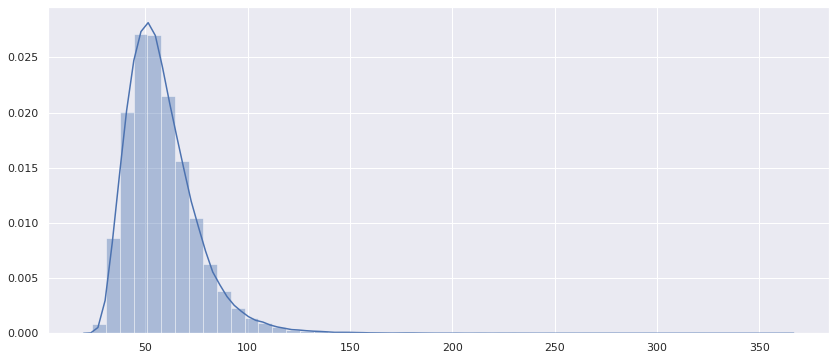

{
  "len": 318435,
  "max": 362.75238,
  "min": 23.999325,
  "mean": 58.19257632101999,
  "median": 55.250603,
  "mode": 62.358997,
  "stdev": 17.24609833499237
}

max_scores



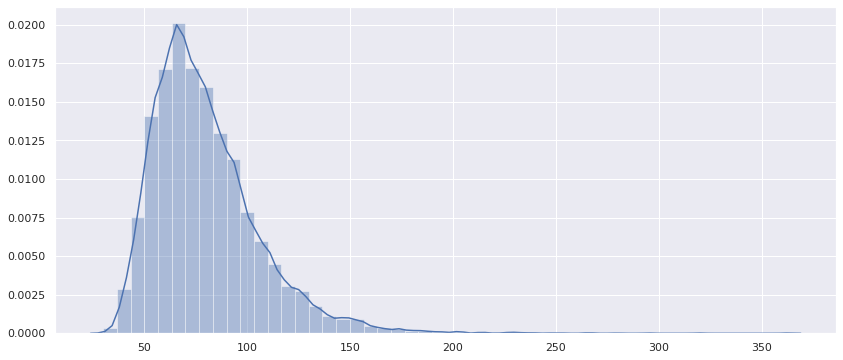

{
  "len": 318435,
  "max": 362.75238,
  "min": 30.198439,
  "mean": 79.86192916369117,
  "median": 75.05832,
  "mode": 70.99975,
  "stdev": 25.931210141723195
}

query_char_lens



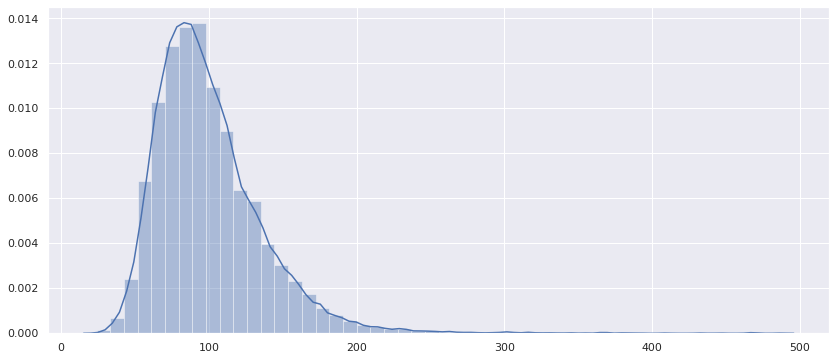

{
  "len": 318435,
  "max": 487,
  "min": 24,
  "mean": 100.21928180005338,
  "median": 94,
  "mode": 86,
  "stdev": 36.85153997730753
}

content_char_lens



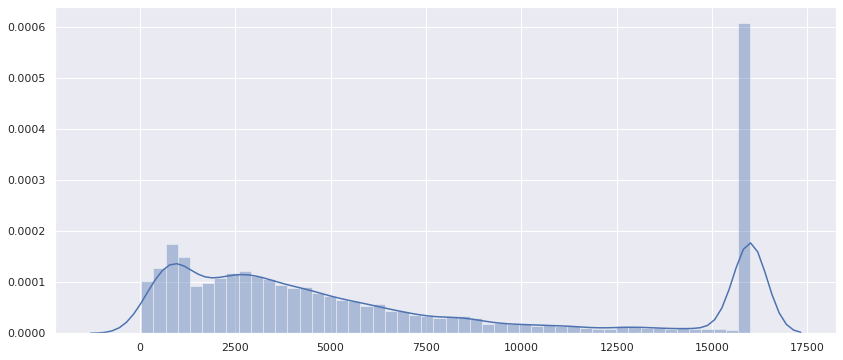

{
  "len": 318435,
  "max": 16000,
  "min": 34,
  "mean": 6523.374541115141,
  "median": 4412,
  "mode": 16000,
  "stdev": 5570.908289138808
}

title_char_lens



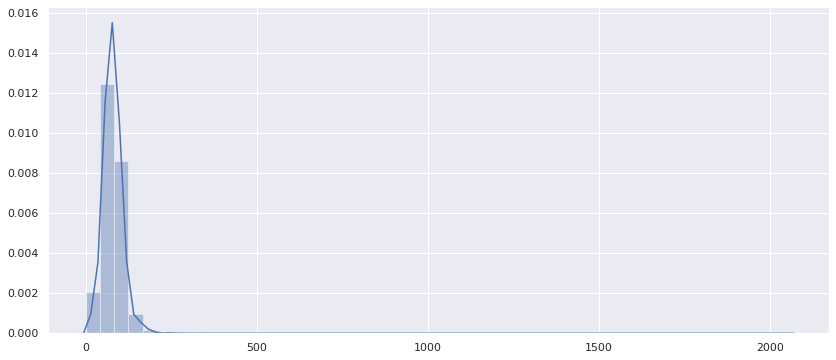

{
  "len": 318435,
  "max": 2062,
  "min": 0,
  "mean": 77.36114748692826,
  "median": 76,
  "mode": 79,
  "stdev": 31.181849953089827
}



In [11]:
to_plot = {
    "scores": scores,
    "max_scores": max_scores,
    "query_char_lens": query_char_lens,
    "content_char_lens": content_char_lens,
    "title_char_lens": title_char_lens
}
for k, v in to_plot.items():
    print(k)
    print()
    print(json.dumps(stats(v, plot=True), indent=2))
    print()

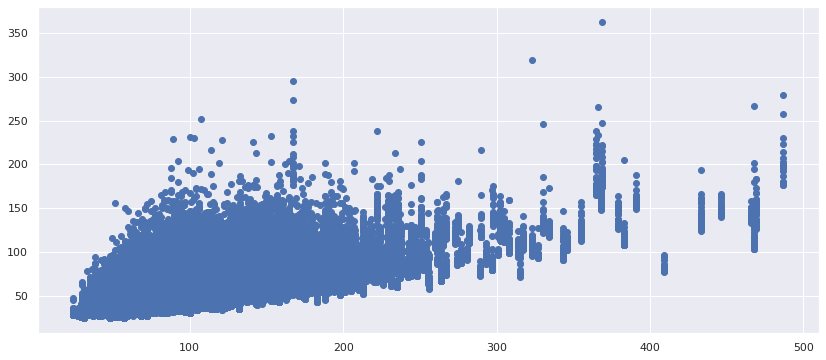

In [12]:
plt.scatter(query_char_lens, scores)

# Hits vs Score
---

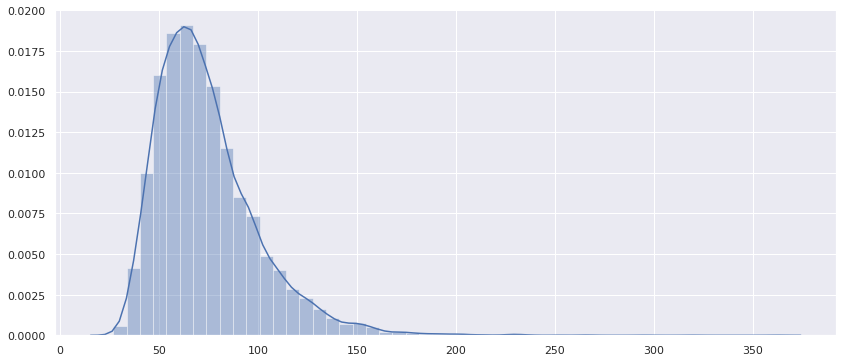

{'len': 13879,
 'max': 362.75238,
 'min': 26.971743,
 'mean': 74.21140728662007,
 'median': 69.32515,
 'mode': None,
 'stdev': 25.671788869784965}

In [13]:
# scores for hits
stats([score for score, ishit in zip(scores, is_valid_hit) if ishit], plot=True)

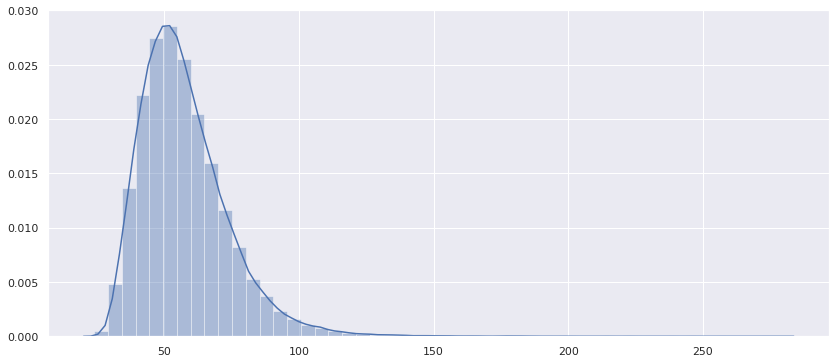

{'len': 304556,
 'max': 279.83707,
 'min': 23.999325,
 'mean': 57.46257804493427,
 'median': 54.80919,
 'mode': 62.358997,
 'stdev': 16.392809680313267}

In [14]:
# scores for non hits
stats([score for score, ishit in zip(scores, is_valid_hit) if not ishit], plot=True)